# Objetivo do projeto

O objetivo do projeto é testar diversos modelos de previsão de séries temporais para prever as cotações de fechamento do índice Bovespa a cada mês. 

Os modelos utilizados são:
<ol start="1">
    <li> ARIMA:</li>
    <p>
    <li> Exponential Smoothing</li>
    <p>
    <li> Redes Neurais Convolucionais</li>
    <p>
    <li> Redes Neurais Recorrentes</li>
</ol>

Este projeto não tem como objetivo ser utilizado para especulação financeira sobre os ativos ou recomendação de compra e venda. A compra e venda de ativos deve estar fundamentada em estratégias além do escopo deste projeto.

A intenção real do projeto é ensinar o funcionamento de diversos modelos de previsão, como realizar validação cruzada em séries temporais e avaliar os resultados obtidos, tudo isso utilizando uma temática interessante.

# Importação de bibliotecas e dados

## Importando principais bibliotecas para o estudo

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
from IPython.display import display

Vamos importar os dados e explorar seu comportamento.

A biblioteca do Yahoo Finance se encontra no link [Yahoo Finance Library](https://pypi.org/project/yfinance/).

Os Tickers de ações e índices podem ser pesquisados no site do [Yahoo Finance](https://finance.yahoo.com/).

In [2]:
# Ticker IBOVESPA no Yahoo Finance
ticker = '^BVSP'
tickerData = yf.Ticker(ticker=ticker)


# Frequência de atualização dos dados de um mês
interval = '1mo'

# Data de início da requisição de cotações
start = '1993-04-27' # Data da primeira cotação no Yahoo
end = '2021-12-09' 

# Acessando a série histórica
tickerDf = tickerData.history(interval=interval,start=start)
# Acessando os primeiros dados
tickerDf.head(15)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-05-01,24.100000,35.599998,23.799999,34.900002,0,0,0
1993-06-01,35.400002,54.799999,35.400002,53.700001,0,0,0
1993-07-01,53.700001,67.400002,51.700001,65.599998,0,0,0
1993-08-01,65.599998,100.099998,60.599998,96.400002,0,0,0
1993-09-01,96.400002,150.300003,96.400002,146.600006,0,0,0
1993-10-01,146.600006,207.000000,146.600006,184.399994,0,0,0
1993-11-01,184.399994,287.000000,184.399994,274.000000,0,0,0
1993-12-01,274.000000,378.600006,266.799988,375.500000,0,0,0
1994-01-01,375.500000,741.700012,373.399994,740.599976,0,0,0


Como estamos interessados somente nos fechamentos, iremos armazenar somente as colunas Date e Close.

In [3]:
closeDf = tickerDf.reset_index()[['Date','Close']].copy()
closeDf.head()

,Date,Close
0,1993-05-01,34.900002
1,1993-06-01,53.700001
2,1993-07-01,65.599998
3,1993-08-01,96.400002
4,1993-09-01,146.600006


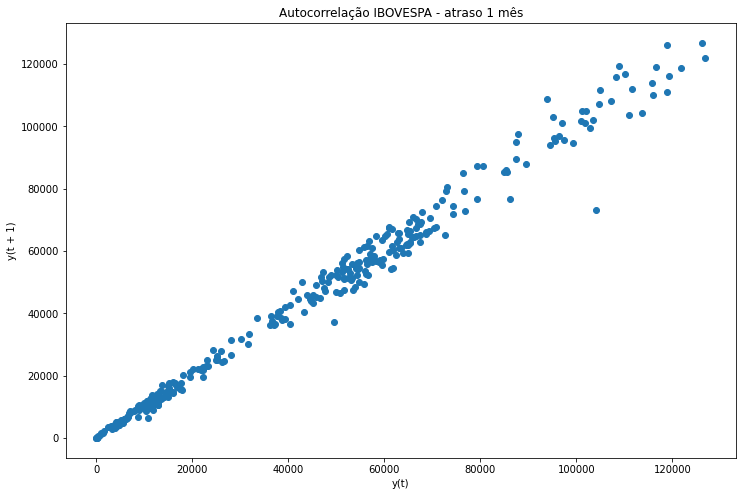

In [4]:
# Verificando o espalhamento das cotações após um mês
fig = plt.figure(figsize=(12,8))
pd.plotting.lag_plot(closeDf['Close'],lag=1)
plt.title('Autocorrelação IBOVESPA - atraso 1 mês')
plt.show()

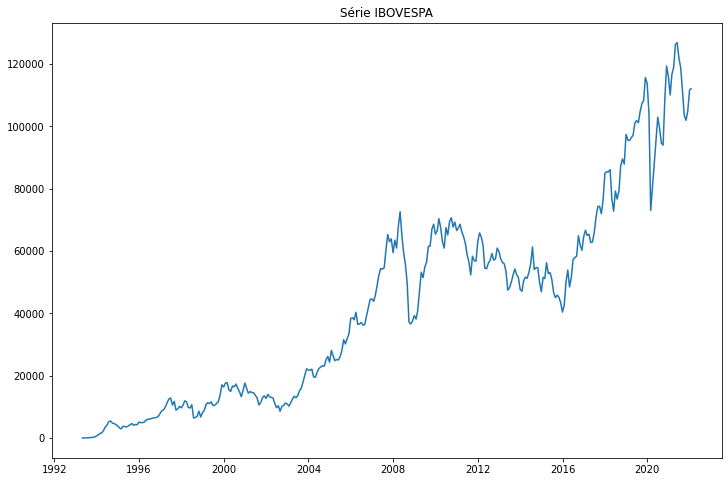

In [5]:
# Verificando o comportamento da série temporal
fig = plt.figure(figsize=(12,8))
plt.plot(closeDf['Date'],closeDf['Close'])
plt.title('Série IBOVESPA')
plt.show()

Uma correlação forte entre um valor da série $y(t)$ para um momento $t$ e outro com atraso de um mês $y(t+1)$.

Vemos também que o espalhamento de uma forma geral é proporcional ao valor $y(t)$. 

Além disso, os maiores espalhamentos são em geral para baixo. Apesar da tendência em geral ser de alta, as maiores variações são de queda da bolsa.

# ARIMA

Neste notebook iremos treinar o modelo ARIMA. 

ARIMA é uma abreviação do seguinte nome: Autoregressive Integrated Moving Average. O modelo ARIMA é um modelo de previsão de séries temporais, que é a junção de outros modelos listados à seguir:

<ul>
    <li>AR (Autoregressive): Esta parte do modelo ARIMA usa diretamente os dados anteriores da série temporal para prever o próximo valor.</li>
    <p>
    <li>I (Integrated): Esta parte adiciona uma diferença com atraso na autoregressão, com o intuito de auxiliar na captação do comportamento estacionário, ou seja, utilizado quando a série é independente do tempo. Por exemplo, séries com tendência de crescimento ou periódicas não são estacionárias. </li>
    <p>
    <li>MA (Moving Average): Não confundir com a média móvel, que é um caso especial de autoregressão. O modelo moving average utiliza os resíduos anteriores para prever o próximo valor. Mais especificamente, utiliza uma combinação dos valores erros de previsão anteriores para prever o próximo valor da série.</li>
</ul>


Os principais parâmetros do modelo ARIMA são (p,d,q):


<ul>
    <li>p é o número de observações anteriores utilizadas no AR.</li>
    <p>
    <li>d é o atraso utilizado na diferença, referente à integração do modelo.</li>
    <p>
    <li>q é o número de resíduos anteriores utilizados no MA</li>
</ul>

Para informações mais detalhadas pode-se consultar as seguintes referências:
<ul>
    <li><a href="https://otexts.com/fpp2/arima.html">Forecasting: Principles and Practice.</a></li>
    <p>
    <li><a href="https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/">How to Create an ARIMA Model for Time Series Forecasting in Python.</a></li>
    <p>
    <li><a href="https://towardsdatascience.com/deep-understanding-of-the-arima-model-d3f0751fc709">Deep understanding of the ARIMA model.</a></li>
</ul>

# Implementando o modelo


O primeiro modelo terá as seguintes especificações:

* O modelo utilizado será o ARIMA com a classe ``statsmodels.tsa.statespace.sarimax.SARIMAX``. A fim de curiosidade, o modelo SARIMAX é um generalização do modelo ARIMA, que pode incluir parâmetros de sazonalidade e variáveis externas, que não iremos utilizar.

* Os dados de treino serão transformados para o intervalo $[0,1]$ utilizando a função a classe ``MinMaxScaler``.

* Os hiperparâmetros serão escolhidos 10 combinações de hiperparâmetros, selecionados aleatoriamente. Para cada combinação verificamos seus recpectivos desempenhos com validação cruzada 5-fold, com a classe ``sklearn.model_selection.TimeSeriesSplit``. Ou seja, uma adaptação da classe ``sklearn.model_selection.RandomizedSearchCV`` para séries temporais \[Veja a [documentação do Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html)\].

* A divisão de treino e teste é 90%-10%.

* Os hiperparâmetros p, d e q são escolhidos nos conjuntos ``range(0,21)``, ``range(0,5)`` e ``range(0,10)``, respectivamente. Essa escolha é somente para fins ilustrativos, uma análise mais profunda deveria ser feita para uma decisão mais consciente dos hiperparâmetros.

* A métrica considerada na validação cruzada é o erro percentual médio (MAPE), dado por $${\rm MAPE} = \sum_{i=1}^m \frac{|y_{i} - \hat{y}_{i}|}{|y_{i}|}.$$

### Importando Módulos

In [6]:
# Pré-processamento
from sklearn.preprocessing import MinMaxScaler

# Validação Cruzada em Séries Temporais
from sklearn.model_selection import TimeSeriesSplit as tss

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


# Utilidades
from itertools import product # Produto cartesiano de listas
from tqdm import tqdm # Barra de progresso

# SARIMAX statsmodel -> SARIMAX é uma generalização do modelo ARIMA
# Levaremos em consideração somente as configurações do modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Utilizado para ignorar os avisos 
# Só utilize quando realmente quiser uma saída limpa
import warnings

### Preparação para a Validação Cruzada

In [7]:
# Hiperparâmetros
ps = range(0,21)
ds = range(0,5)
qs = range(0,10)


hyperparameters = list(product(ps,ds,qs))

# Embaralhando os hiperparâmetros
np.random.seed(42)
np.random.shuffle(hyperparameters)
np.random.seed(None)

# Número de iterações na escolha do hiperparâmetro
n_iter = 20
hyperparameters = hyperparameters[:n_iter]


# Definindo a série temporal
y = closeDf['Close'].values

# Número de observações
n_examples = len(y)

# Tamanho Conjunto de Treino de 90% do conjunto
train_size = int(n_examples*0.9)
# Tamanho Conjunto de Teste de 10% do conjunto (Complemento do conjunto)
test_size = n_examples - train_size

# Divisão Treino-Teste
y_train = y[:train_size]
y_test = y[train_size:]

# Mudança de Escala -> facilita treinamento e torna o modelo mais estável
sc_y = MinMaxScaler()
y_train_sc = sc_y.fit_transform(np.expand_dims(y_train,1))
y_test_sc = sc_y.transform(np.expand_dims(y_test,1))

# Validação Cruzada Séries Temporais
n_splits = 5
tscv = tss(n_splits=n_splits,test_size=test_size)

### Validação de hiperparâmetros

In [8]:
# Dicionários para armazenamento de hiperparâmetros e desempenho
hyperparameters_storage = {}
performances_storage = {}

# Filtrar os avisos, para evitar uma saída muito longa no treino do modelo SARIMAX
warnings.filterwarnings("ignore")

# Realizando Validação Cruzada com Busca Aleatória 
# Hiperparâmetros com barra de progresso
for (p,d,q) in tqdm(hyperparameters):
    # Score da validação
    cv_score_list = np.zeros(n_splits)
    for i,(train_idx,val_idx) in enumerate(tscv.split(y_train)):
        # Conjunto de treino e validação com mudança de escala
        train_sc = y_train_sc[train_idx]
        val_sc = y_train_sc[val_idx]
        # Conjunto de validação e seu tamanho
        val = y_train[val_idx]
        val_size = len(val_idx)
        # Definindo o modelo SARIMAX com os dados de treino
        model = SARIMAX(train_sc,initialization='approximate_diffuse',order=(p,d,q))
        # Treinando o modelo
        model_fit = model.fit(maxiter=200)

        # ** Previsão para os dados de validação **
        # val_pred_sc armazenará as previsões
        val_pred_sc = []
        # Histórico para realizar previsões
        history = train_sc
        # Previsão
        ynew = model_fit.forecast()[0]
        val_pred_sc.append(ynew)

        for k in range(1,val_size):
          # Atualizando o histórico
          history = np.concatenate((history,[val_sc[k-1]]))
          # .apply() é um método para atualizar o histórico de dados
          model_fit = model_fit.apply(history,refit=False)
          # Previsão
          ynew = model_fit.forecast()[0]
          val_pred_sc.append(ynew)

        # Preparando para retornar à escala original
        val_pred_sc = np.array([val_pred_sc[-val_size:]]).T
        # Revertendo a escala
        val_pred = sc_y.inverse_transform(val_pred_sc)
        # Armazenando o score de validação
        score = 100*mean_absolute_percentage_error(val,val_pred)
        cv_score_list[i] = score
    
    # Estatísticas score de validação
    cv_mean_score = np.mean(cv_score_list)
    cv_median_score = np.median(cv_score_list)
    cv_std_score = np.std(cv_score_list)
    cv_IQR_score = np.quantile(cv_score_list,0.75) - np.quantile(cv_score_list,0.25)
    
    # Armazenando hiperparâmetros e performances dos modelos validados
    hyperparameters_dict = {'p': p, 'd': d, 'q': q}
    performances_dict = {'MAPE CV Médio':cv_mean_score,
                         'MAPE CV Mediano':cv_median_score,
                         'MAPE CV Std.':cv_std_score,
                         'MAPE CV IQR':cv_IQR_score}


    hyperparameters_storage.update({j: hyperparameters_dict})
    performances_storage.update({j:performances_dict})
    j += 1
# Reabilitando os avisos
warnings.filterwarnings("default")

100%|██████████| 20/20 [04:12<00:00, 12.62s/it]


In [9]:
# Biblioteca json
import json

# Salvando dicionários como json (o formato json é similar a dicionários em python)
# O intuito é armazenar performances, evitando repetir os testes.
with open('hyperparameters.json','w') as f:
    json.dump(hyperparameters_storage,f)


with open('performances.json','w') as f:
    json.dump(performances_storage,f)

In [10]:
# Dataframe dos hiperparâmetros
hyperparameters_DataFrame = pd.DataFrame(hyperparameters_storage).T
# Dataframe das performances
performance_DataFrame = pd.DataFrame(performances_storage).T
# Dataframe das combinando hiperparâmetros e performances
models_df = hyperparameters_DataFrame.join(performance_DataFrame,how='inner')
display(models_df)

# Índices de menor métrica performance
i_mean = performance_DataFrame['MAPE CV Médio'].argmin()
i_median = performance_DataFrame['MAPE CV Mediano'].argmin()

print('Melhor MAPE Médio (Validação Cruzada):')
display(models_df.iloc[i_mean:i_mean+1])



print('Melhor MAPE Mediano (Validação Cruzada):')
display(models_df.iloc[i_median:i_median+1])

,p,d,q,MAPE CV Médio,MAPE CV Mediano,MAPE CV Std.,MAPE CV IQR
0,7,0,2,5.468538,5.348569,0.771721,1.201709
1,13,3,9,6.334390,5.992834,1.374488,1.156750
2,9,3,5,6.479284,5.951572,1.237447,1.206389
3,7,3,8,6.333686,5.977544,1.160030,2.170906
4,0,3,1,6.731783,6.849936,0.740910,0.820950
5,8,4,2,6.380807,6.234409,0.787306,0.831592
6,3,4,8,5.441166,5.290731,0.953446,0.251102
7,8,2,5,5.335540,4.822403,1.140516,0.223370
8,2,0,7,5.207658,4.876461,0.767149,0.247342
9,14,1,4,5.505297,5.051676,1.295858,0.222693


Melhor MAPE Médio (Validação Cruzada):


,p,d,q,MAPE CV Médio,MAPE CV Mediano,MAPE CV Std.,MAPE CV IQR
16,12,1,7,5.038202,4.754023,0.872537,0.671712


Melhor MAPE Mediano (Validação Cruzada):


,p,d,q,MAPE CV Médio,MAPE CV Mediano,MAPE CV Std.,MAPE CV IQR
16,12,1,7,5.038202,4.754023,0.872537,0.671712


Testaremos os modelos com menor erro percentual absoluto médio e mediano, dos valores obtidos na validação cruzada.

### Menor MAPE médio

In [11]:
# Filtrar os avisos, para evitar uma saída muito longa
warnings.filterwarnings("ignore")
p,d,q = hyperparameters_storage[i_mean].values()


model = SARIMAX(y_train_sc,initialization='approximate_diffuse',order=(p,d,q))
model_fit_mean = model.fit(maxiter=200)



# prediction_sc armazenará as previsões
prediction_sc = []
# Histórico para realizar predições
history = y_train_sc.copy()
# Previsão
ynew = model_fit_mean.forecast()[0]
prediction_sc.append(ynew)

for i in tqdm(range(1,test_size)):
  # Atualizando o histórico
  history = np.concatenate((history,[y_test_sc[i-1]]))
  # .apply() é um método para atualizar o histórico de dados
  model_fit = model_fit_mean.apply(history,refit=False)
  # Previsão
  ynew = model_fit.forecast()[0]
  prediction_sc.append(ynew)





# Preparando para reverter à escala original
test_pred_sc = np.array([prediction_sc[-test_size:]]).T
# Revertendo escala
test_pred = sc_y.inverse_transform(test_pred_sc)
# Avaliando os erros
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


# Armazenando performances
test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}


with open('test_performances_mean.json','w') as f:
    json.dump(test_performances_dict,f)



# Retorna à configuração de avisos padrão
warnings.filterwarnings("default")

# Mostrando os resultados
print('(p,d,q)=(%d,%d,%d)'%(p,d,q))
for key in test_performances_dict.keys():
    print(key + ': %1.4f' %test_performances_dict[key])

100%|██████████| 34/34 [00:00<00:00, 95.83it/s]

(p,d,q)=(12,1,7)
Test MAPE: 5.4891
Test MSE: 60203832.8401
Test RMSE: 7759.1129
Test MAE: 5413.6630


### Menor MAPE mediano

In [12]:
# Filtrar os avisos, para evitar uma saída muito longa
warnings.filterwarnings("ignore")
p,d,q = hyperparameters_storage[i_median].values()


model = SARIMAX(y_train_sc,initialization='approximate_diffuse',order=(p,d,q))
model_fit_median = model.fit(maxiter=200)



# prediction_sc armazenará as previsões
prediction_sc = []
# Histórico para realizar predições
history = y_train_sc.copy()
# Previsão
ynew = model_fit_median.forecast()[0]
prediction_sc.append(ynew)

for i in tqdm(range(1,test_size)):
  # Atualizando o histórico
  history = np.concatenate((history,[y_test_sc[i-1]]))
  # .apply() é um método para atualizar o histórico de dados
  model_fit = model_fit_median.apply(history,refit=False)
  # Previsão
  ynew = model_fit.forecast()[0]
  prediction_sc.append(ynew)





# Preparando para reverter à escala original
test_pred_sc = np.array([prediction_sc[-test_size:]]).T
# Revertendo escala
test_pred = sc_y.inverse_transform(test_pred_sc)
# Avaliando os erros
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


# Armazenando performances
test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}


with open('test_performances_median.json','w') as f:
    json.dump(test_performances_dict,f)



# Retorna à configuração de avisos padrão
warnings.filterwarnings("default")

# Mostrando os resultados
print('(p,d,q)=(%d,%d,%d)'%(p,d,q))
for key in test_performances_dict.keys():
    print(key + ': %1.4f' %test_performances_dict[key])

100%|██████████| 34/34 [00:00<00:00, 94.73it/s]

(p,d,q)=(12,1,7)
Test MAPE: 5.4891
Test MSE: 60203832.8401
Test RMSE: 7759.1129
Test MAE: 5413.6630


Vemos que os hiperparâmetros p, d e q iguais a 12, 1 e 7 apresentam menor erro no conjunto de teste. Portanto usaremos este modelo para entender o comportamento dos conjuntos de dados.

# Verificando resultados do modelo

In [13]:
# Escolhendo o melhor modelo
model_fit = model_fit_mean

In [14]:
# Realizando novamente as previsões
prediction_sc = []
history = y_train_sc.copy()
ynew = model_fit_median.forecast()[0]
prediction_sc.append(ynew)
for i in tqdm(range(1,test_size)):
  history = np.concatenate((history,[y_test_sc[i-1]]))
  model_fit = model_fit_median.apply(history,refit=False)
  ynew = model_fit.forecast()[0]
  prediction_sc.append(ynew)

prediction_sc = np.array([prediction_sc[-test_size:]]).T

100%|██████████| 34/34 [00:00<00:00, 98.10it/s] 


In [15]:
# Calculando os resíduos e resíduos percentuais
prediction = sc_y.inverse_transform(prediction_sc)
residual = prediction[-test_size:].ravel() - y_test
residual_percentual = 100*residual/y_test

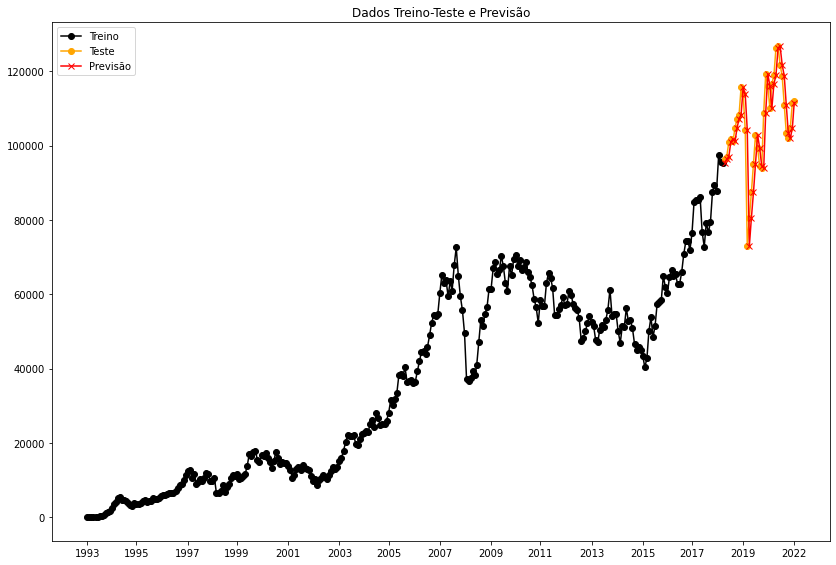

In [16]:
# Formatação de datas matplotlib
import matplotlib.dates as mdates

# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



train_idx = np.array(range(train_size))
test_idx = np.array(range(train_size,n_examples))


plt.title('Dados Treino-Teste e Previsão')
ax.plot(closeDf['Date'][train_idx],y_train,color='k',marker='o',label = 'Treino')
ax.plot(closeDf['Date'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(closeDf['Date'][test_idx],prediction[-test_size:],marker = 'x',color = 'red',label = 'Previsão')



# Formatando datas
index_list = np.linspace(0,n_examples-1,15,dtype=int)

plt.xticks(ticks=closeDf['Date'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.legend()
plt.show()

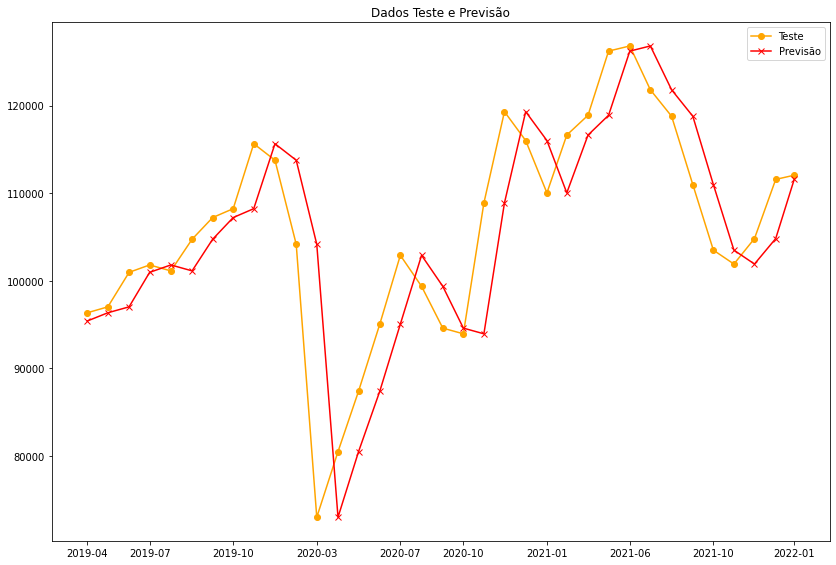

In [17]:
# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Teste e Previsão')
ax.plot(closeDf['Date'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(closeDf['Date'][test_idx],prediction[-test_size:],marker = 'x',color = 'red',label = 'Previsão')





# Formatando datas
index_list = np.linspace(train_size,n_examples-1,10,dtype=int)

plt.xticks(ticks=closeDf['Date'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

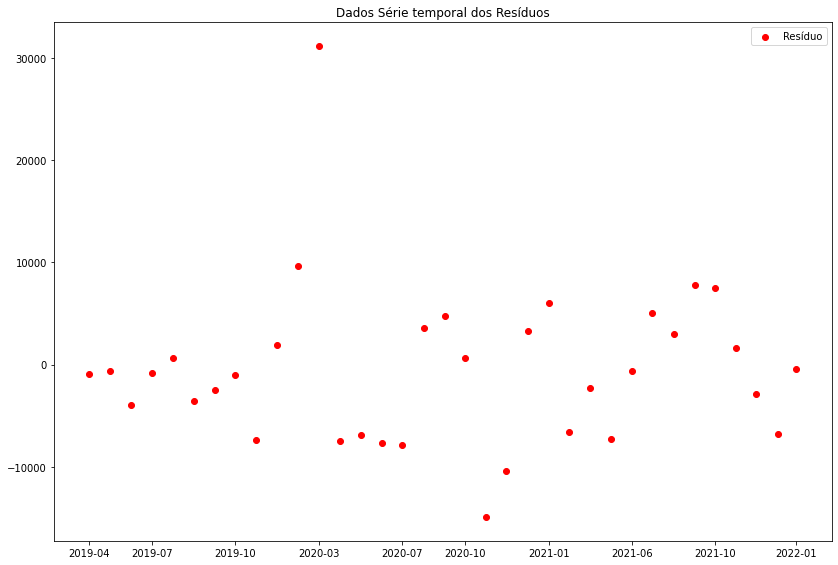

In [18]:
# Plotando Gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(closeDf['Date'][test_idx],residual,marker = 'o',color = 'red',label = 'Resíduo')




# Formatando datas
index_list = np.linspace(train_size,n_examples-1,10,dtype=int)

plt.xticks(ticks=closeDf['Date'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

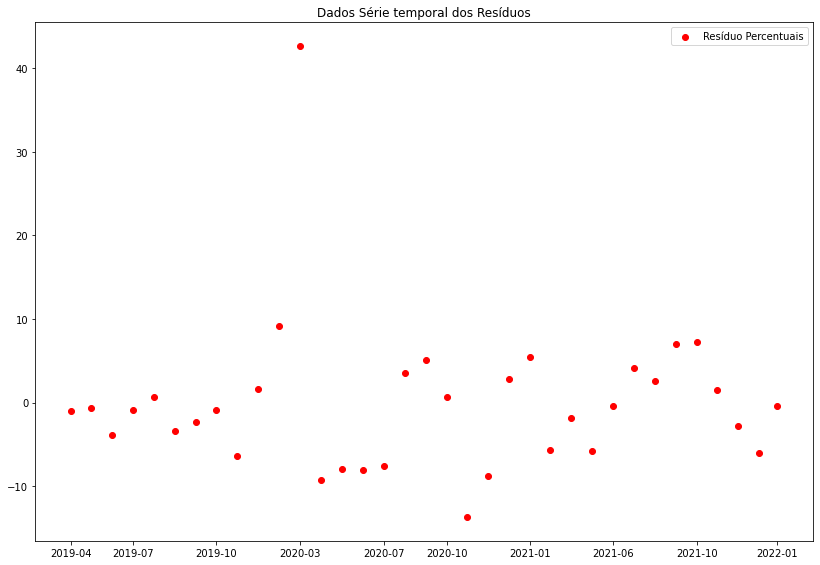

In [19]:
# Plotando gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(closeDf['Date'][test_idx],residual_percentual,marker = 'o',color = 'red',label = 'Resíduo Percentuais')


# Formatando datas
index_list = np.linspace(train_size,n_examples-1,10,dtype=int)

plt.xticks(ticks=closeDf['Date'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

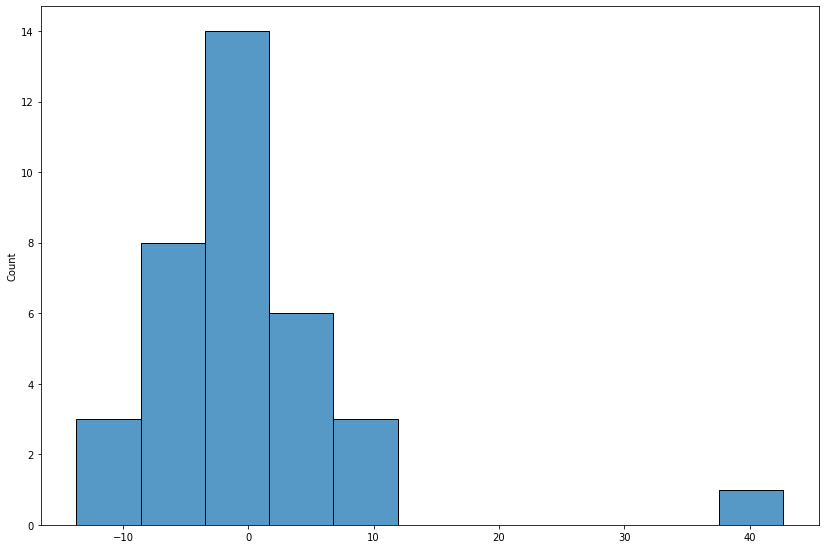

In [20]:
# Histograma Resíduos Percentuais
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])

sns.histplot(residual_percentual)

plt.show()

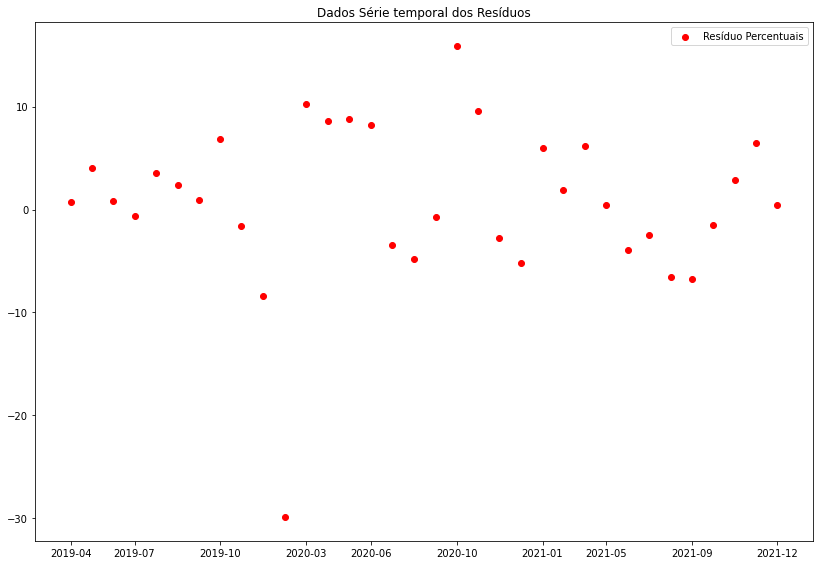

In [21]:
percentual_variation = 100*np.diff(y_test)/y_test[:-1]

import matplotlib.dates as mdates
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])
# m = len(test)
index_list = np.linspace(train_size,n_examples-2,10,dtype=int)


test_idx = np.array(range(train_size,n_examples-1))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(closeDf['Date'][test_idx],percentual_variation,marker = 'o',color = 'red',label = 'Resíduo Percentuais')
plt.xticks(ticks=closeDf['Date'][index_list])




# fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

In [22]:
test_pred = prediction[-test_size:]
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}

test_performances_dict

{'Test MAPE': 5.489102165333689,
 'Test MSE': 60203832.84011779,
 'Test RMSE': 7759.112890022789,
 'Test MAE': 5413.662956866467}

Vemos um erro percentual médio de 5.48%. A maior fonte de erros é a queda da bolsa, entre Janeiro de 2020 e Maio de 2020, onde ocorreu uma grande queda do IBOVESPA.

Outra grande dificuldade é a aleatoriedade das variações, que sem o contexto de variáveis externas que podem influenciar o modelo.

De certo modo, apesar de toda a modelagem, acredito que o melhor modelo será o mais simples, isto é, utilizando a previsão $\hat{y}_{i} = y_{i-1}$. 

Vamos verificar isso.

In [23]:
# Previsão utilizando o dado anterior
test_pred = np.concatenate(([y_train[-1]],y_test[:-1]))

MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


# Armazenando performances
test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}


with open('test_performances_naive.json','w') as f:
    json.dump(test_performances_dict,f)




# Mostrando os resultados
print('Naive predictor')
for key in test_performances_dict.keys():
    print(key + ': %1.4f' %test_performances_dict[key])

Naive predictor
Test MAPE: 5.4891
Test MSE: 60203833.9155
Test RMSE: 7759.1130
Test MAE: 5413.6629


Neste caso vemos uma redução pouco significativa na precisão das previsões do modelo ARIMA com (p,d,q)=(12,1,7) em relação à previsão $\hat{y}_{i} = y_{i-1}$.

Conseguimos aprender alguns tópicos e tirar algumas conclusões:

* Aprendemos o funcionamento teórico e como utilizar o modelo ARIMA da biblioteca statsmodels.

* Aprendemos a realizar validação cruzada em séries temporais.

* Devemos verificar se os dados são suficientes para realizar algum tipo de previsão. 

* Algumas vezes podemos estar utilizando modelos muito sofisticados em dados que eventualmente não são suficientes para obter resultados satisfatórios. Nesses casos, eventualmente uma solução simples pode ser a melhor opção. Porém, a alternativa mais promissora será, provavelmente, obter dados de melhor qualidade, que em geral é a parte mais difícil e envolve conhecimentos mais profundos, além do conhecimento das cotações.

Apesar de parecer frustrante o fato de o nosso modelo não agregar valor aos dados, ainda assim tivemos uma boa precisão no modelo. Uma boa leitura para entender um pouco melhor os motivos da dificuldade é a seguinte: [No, LSTMs Can’t Predict Stock Prices](https://medium.com/analytics-vidhya/no-lstms-cant-predict-stock-prices-11f10dcb35d6)